## Mini EDA for Causal Analysis

03 de abril 2025

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm 
import causalpy as cp

In [6]:
# Cargar los archivos
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
# Ajustes visuales iniciales
sns.set(style="whitegrid")

**1. Modelo Predictivo:**
- Variable respuesta: Exited (abandono del cliente / churn).
- Debemos explorar variables predictivas relevantes.

**2. Enfoque Causal:**
- Debemos identificar variables que puedan funcionar como intervenciones ("tratamientos") o variables clave desde un enfoque conductual como:
- Loss Aversion: Evaluar beneficios percibidos (podría relacionarse a variables como NumOfProducts, Balance, o EstimatedSalary).



---

- Distribución y relaciones de variables clave con Exited.

- Potenciales confusores.

- Relaciones que podrían señalar intervenciones conductuales (proxies).



In [ ]:
# Revisa estructura de los datos
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB
None


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
# Nulls 
print(train.isnull().sum())
print(test.isnull().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


In [13]:
train.dtypes


id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

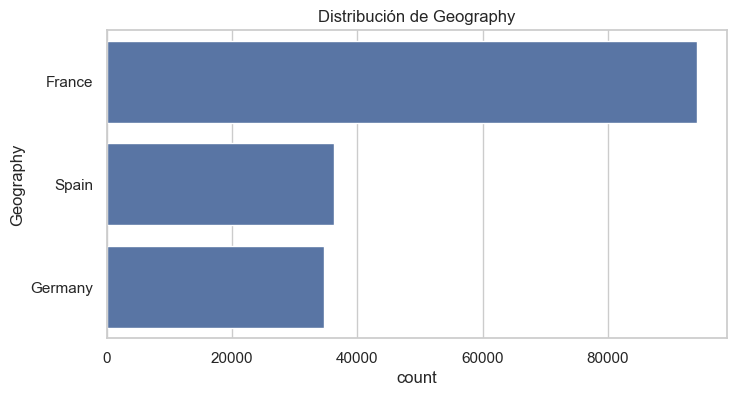

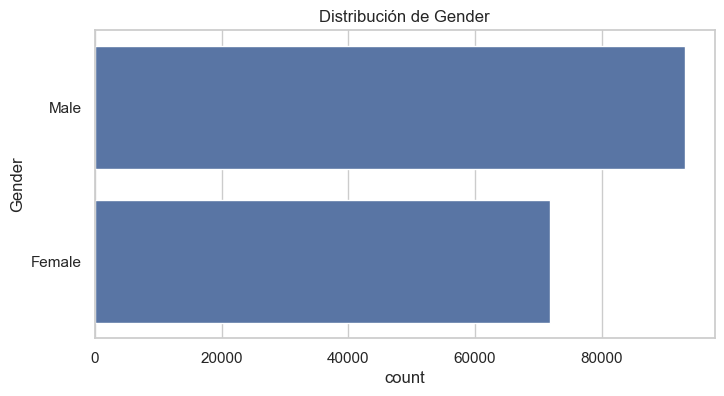

In [16]:
categoricas = train.select_dtypes(include=['object']).drop(columns=['Surname']).columns


for col in categoricas:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=train, order=train[col].value_counts().index)
    plt.title(f"Distribución de {col}")
    plt.show()


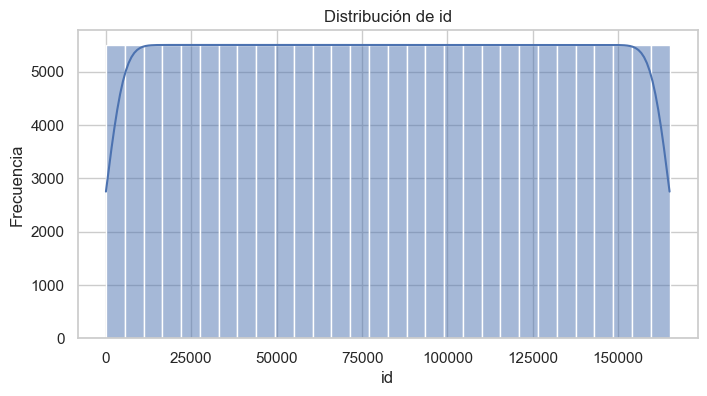

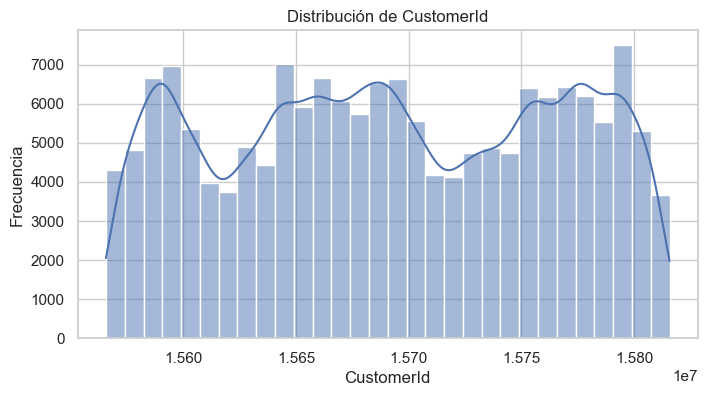

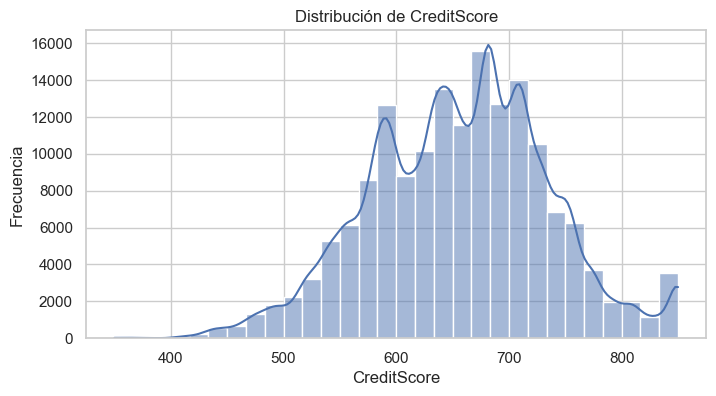

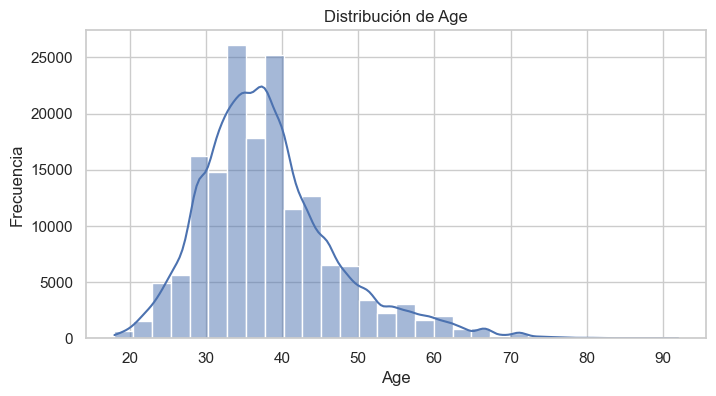

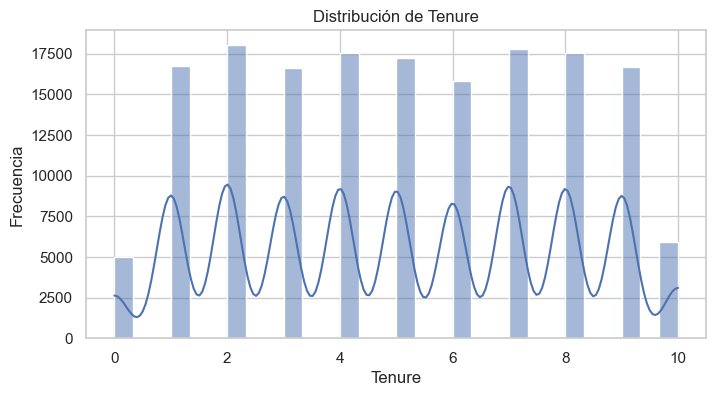

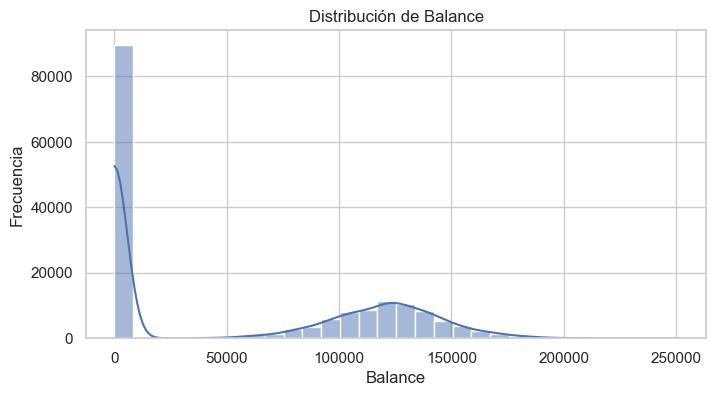

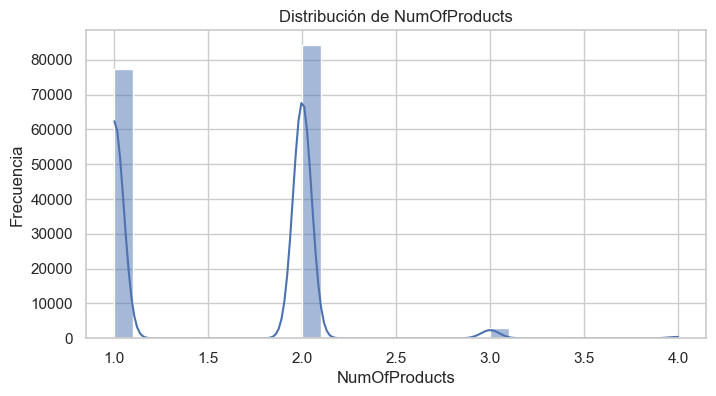

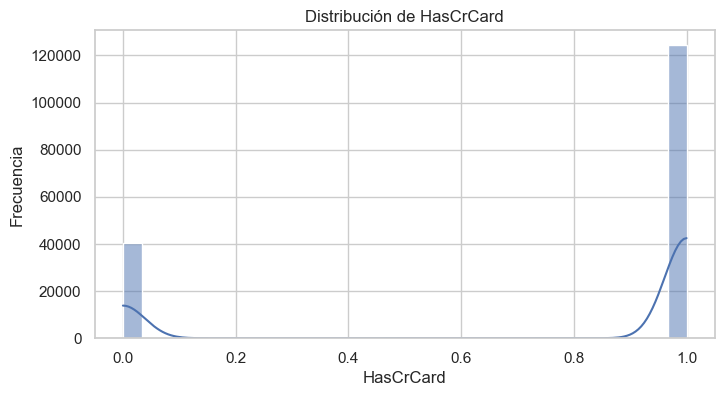

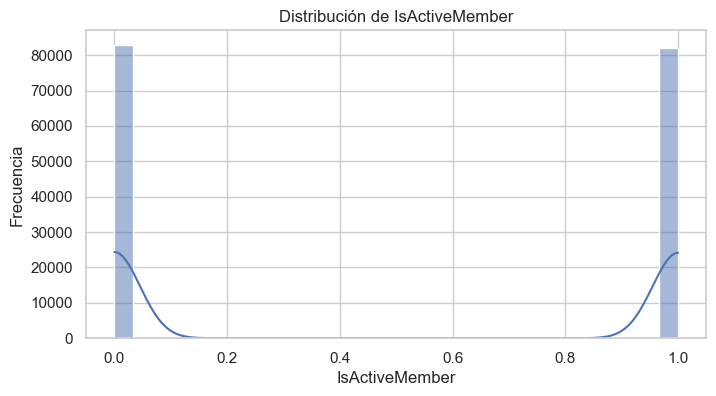

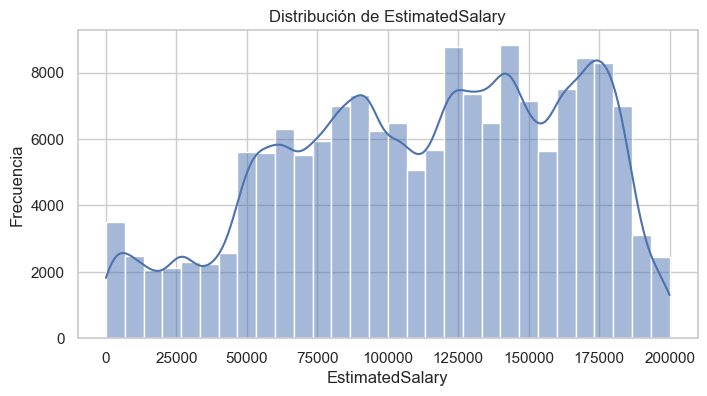

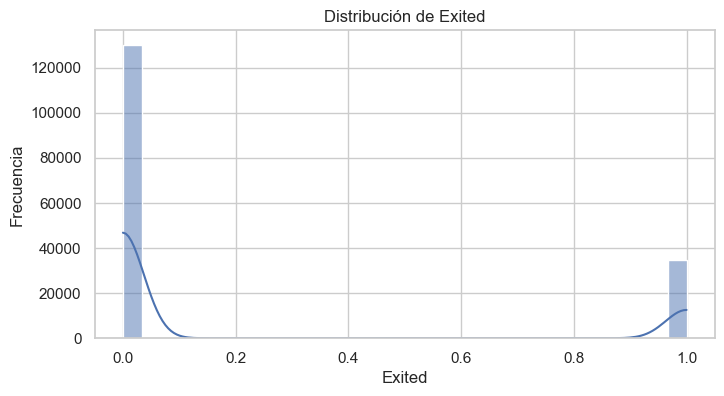

In [17]:
numericas = train.select_dtypes(include=['int64', 'float64']).columns

for col in numericas:
    plt.figure(figsize=(8,4))
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


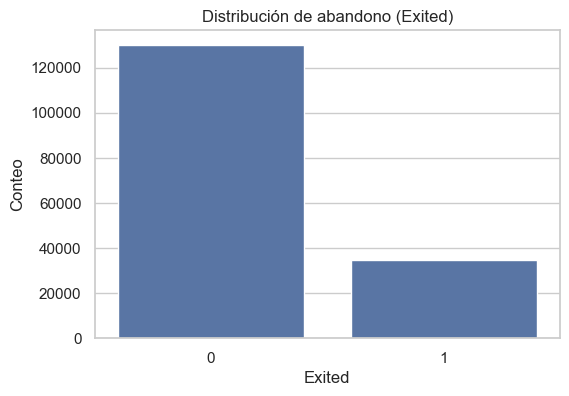

Porcentaje de abandono:
Exited
0    78.840118
1    21.159882
Name: proportion, dtype: float64


In [18]:
# Distribución de variable respuesta
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=train)
plt.title("Distribución de abandono (Exited)")
plt.xlabel("Exited")
plt.ylabel("Conteo")
plt.show()

# Porcentaje de abandono
print("Porcentaje de abandono:")
print(train['Exited'].value_counts(normalize=True) * 100)


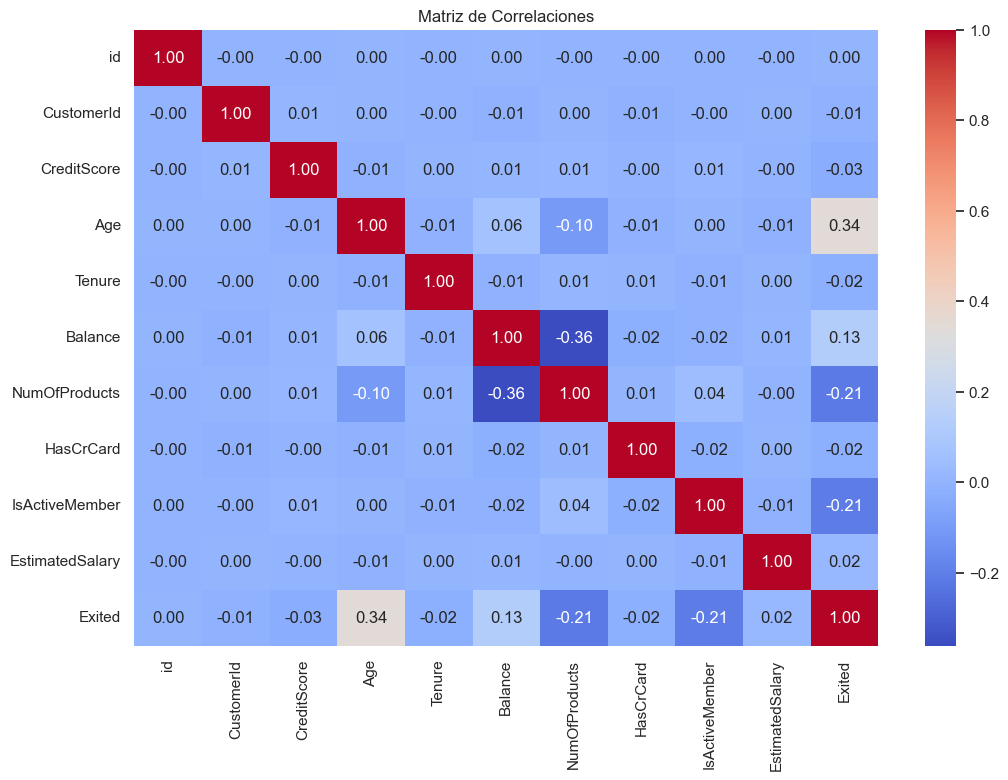

In [19]:
# Correlaciones numéricas
plt.figure(figsize=(12,8))
sns.heatmap(train.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlaciones")
plt.show()


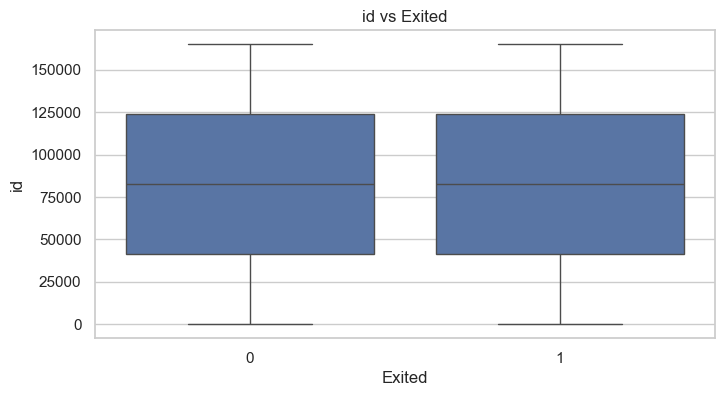

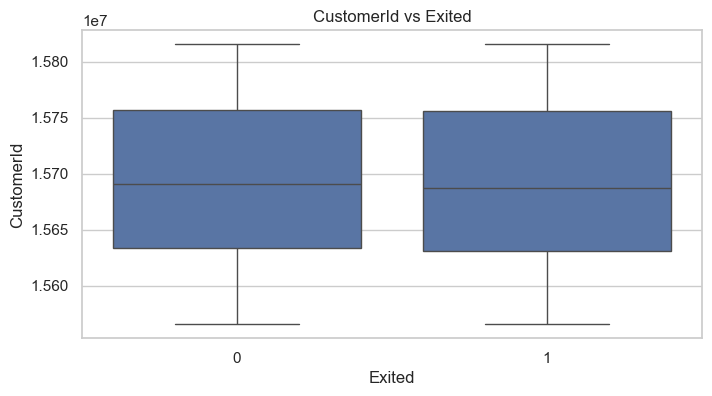

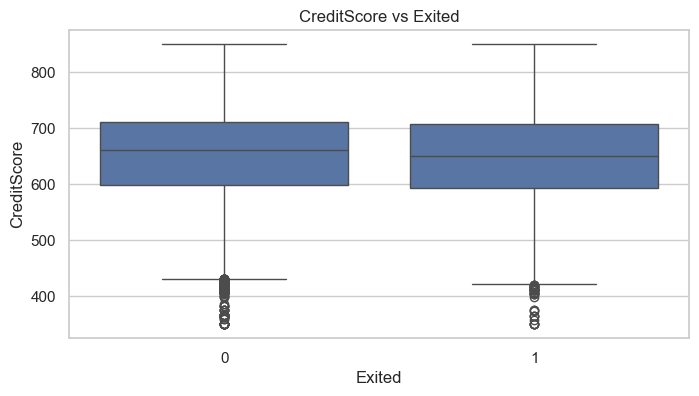

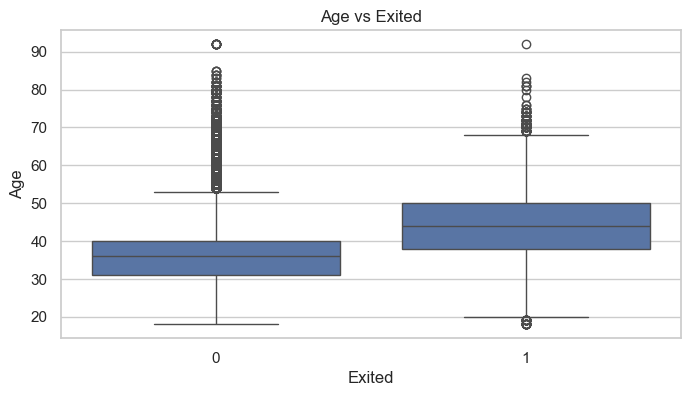

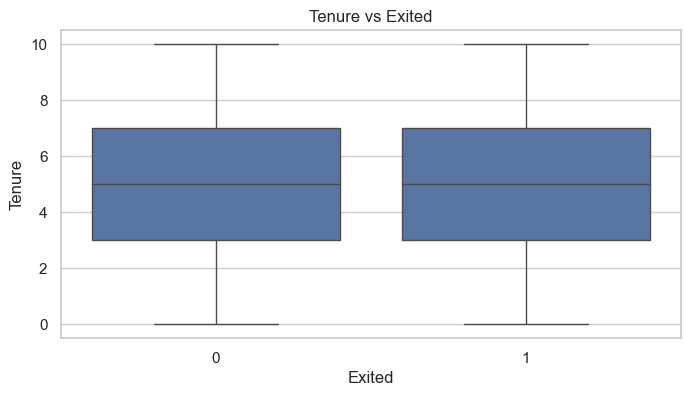

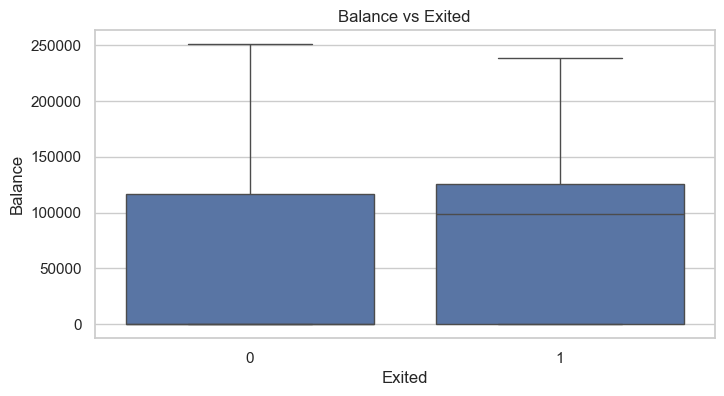

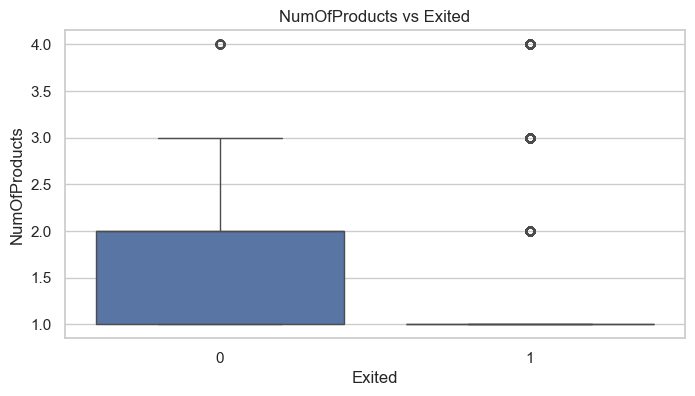

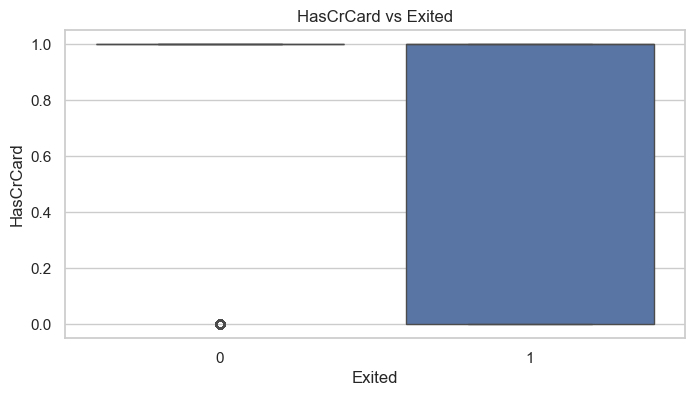

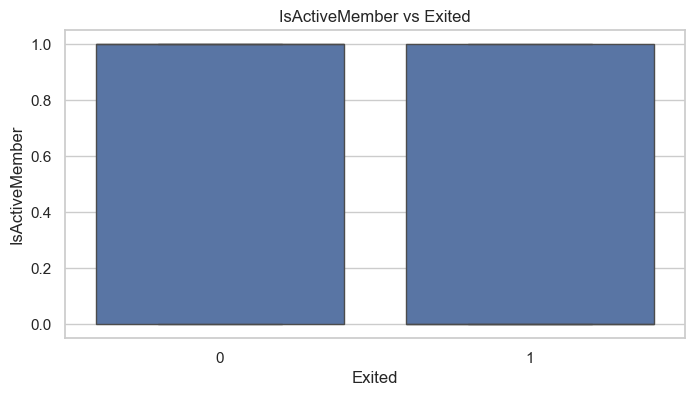

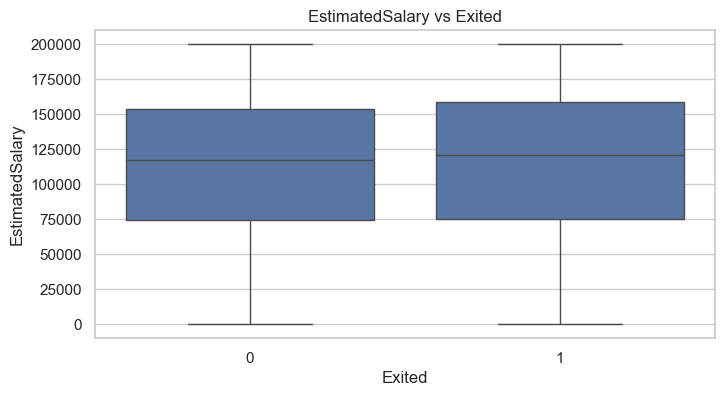

In [20]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop('Exited')

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Exited', y=col, data=train)
    plt.title(f"{col} vs Exited")
    plt.show()


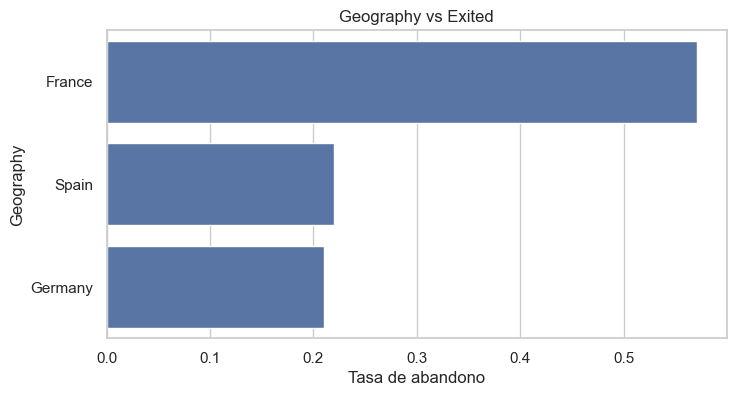

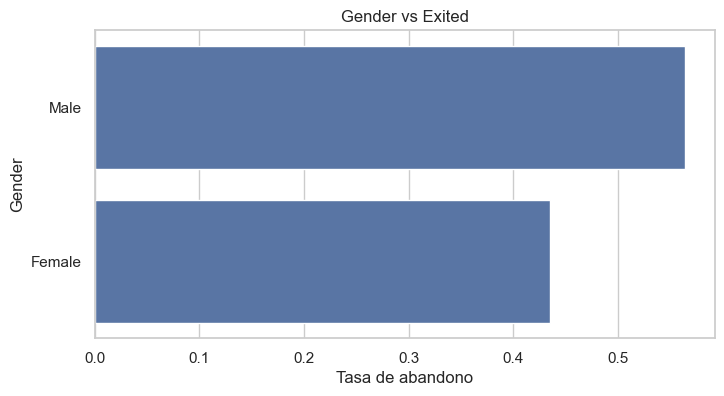

In [21]:
for col in categoricas:
    plt.figure(figsize=(8,4))
    sns.barplot(x='Exited', y=col, data=train, estimator=lambda x: len(x)/len(train))
    plt.title(f"{col} vs Exited")
    plt.xlabel("Tasa de abandono")
    plt.show()


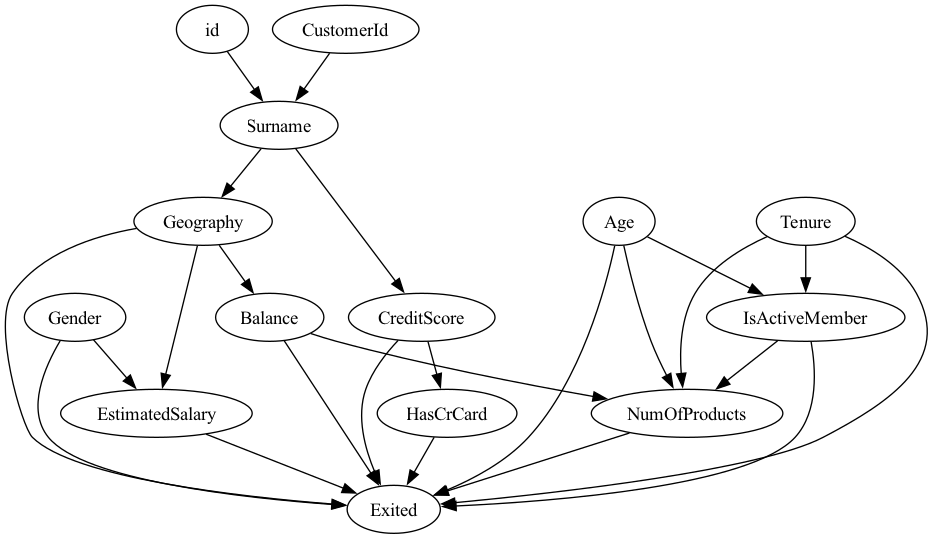

In [30]:
import graphviz
from IPython.display import Image, display

# DAG con todas las variables del dataset
dag_dot = """
digraph {
    // Identificadores (sin efecto causal directo)
    id -> Surname;
    CustomerId -> Surname;

    // Surname como proxy de origen o herencia
    Surname -> Geography;
    Surname -> CreditScore;

    // Relaciones conductuales y financieras
    Geography -> Balance;
    Geography -> EstimatedSalary;
    Geography -> Exited;

    Gender -> EstimatedSalary;
    Gender -> Exited;

    CreditScore -> Exited;
    CreditScore -> HasCrCard;

    Age -> IsActiveMember;
    Age -> NumOfProducts;
    Age -> Exited;

    Tenure -> IsActiveMember;
    Tenure -> NumOfProducts;
    Tenure -> Exited;

    Balance -> NumOfProducts;
    Balance -> Exited;

    HasCrCard -> Exited;

    IsActiveMember -> NumOfProducts;
    IsActiveMember -> Exited;

    NumOfProducts -> Exited;

    EstimatedSalary -> Exited;
}
"""

# Crear y renderizar el DAG
dag = graphviz.Source(dag_dot)
dag.render("dag_completo", format="png", cleanup=True)
display(Image(filename="dag_completo.png"))




**Queremos:**
- Quién se va a ir ?
- Porqué ?
- Qué hacemos con el desbalance de clases ? 

### Feature Engineering

In [32]:
# Copiar el DataFrame original para no sobreescribirlo
train_clean = train.copy()

# Eliminar columnas irrelevantes
train_clean = train_clean.drop(columns=['id', 'CustomerId', 'Surname'])

# Separar variables predictoras (X) y objetivo (y)
X = train_clean.drop(columns='Exited')
y = train_clean['Exited']
